
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase2<br>
    Soft Actor Critic<br>
<font color=696880 size=4>
    Ali Najar-Mohmmad Shafizade-Armin Khosravi




In this notebook, we are going to get familiar with SAC algorithm. Soft Actor Critic (SAC) is an off-policy algorithm that maximizes a combination of expected return **and** entropy. Higher entropy results in higher exploration, which is an important concept in Reinforcement Learning.

## 📦 Setup and Dependencies

Install PyBullet for Physics based environments.

In [1]:
!pip install -q pybullet Box2D
!nvidia-smi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 MB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 29.9 MB/s eta 0:00:00
Fri Sep  5 15:14:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W

Import necessary packages.

In [3]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.distributions import Normal

import warnings
warnings.filterwarnings('ignore')
from gym.wrappers import RecordVideo
import gym
import pybullet_envs
np.bool8 = np.bool_
from tqdm.notebook import trange
from IPython.display import Video

## 📈 Utility codes

We will use this utility function to visualize the training progress.

In [4]:
def plot_learning_curve(x, filename, save_plot=True):
    avg_x = [np.mean(x[np.max([0, i - 100]):i]) for i in range(len(x))]
    plt.figure(dpi=200)
    plt.title('Learning Curve')
    plt.plot(range(len(x)), x, label='score', alpha=0.3)
    plt.plot(range(len(avg_x)), avg_x, label='average score')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    if save_plot:
        plt.savefig(filename + '.png')
    plt.show()

This class implements a **Replay Buffer** to store and sample transitions of the form $(s_t, a_t, r_t, s_{t+1}, d_t)$ to break correlation in updates for stability in mini-batch stochastic gradient descent.


In [5]:
class ReplayBuffer:
    def __init__(self, buffer_size, state_dims, action_dims):
        self.buffer_size = buffer_size
        self.ptr = 0
        self.is_full = False
        # TODO: Initialize buffer arrays to store states, next states, actions, rewards, and done flags
        state_shape = state_dims if isinstance(state_dims, (tuple, list)) else (state_dims,)
        action_shape = action_dims if isinstance(action_dims, (tuple, list)) else (action_dims,)

        self.states = np.zeros((buffer_size, *state_shape), dtype=np.float32)
        self.states_ = np.zeros((buffer_size, *state_shape), dtype=np.float32)
        self.actions = np.zeros((buffer_size, *action_shape), dtype=np.float32)
        self.rewards = np.zeros((buffer_size,), dtype=np.float32)
        self.dones = np.zeros((buffer_size,), dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        idx = self.ptr

        # TODO : Store the transition in the replay buffer
        self.states[idx] = state
        self.actions[idx] = action
        self.rewards[idx] = reward
        self.states_[idx] = state_
        self.dones[idx] = 1.0 if done else 0.0
        self.ptr += 1
        if self.ptr >= self.buffer_size:
            self.ptr = 0
            self.is_full = True

    def load_batch(self, batch_size):
        # TODO: Sample a random batch of transitions from the buffer
        max_mem = self.buffer_size if self.is_full else self.ptr
        if max_mem == 0:
            raise ValueError("Replay buffer is empty. No samples to draw.")

        replace = False if batch_size <= max_mem else True
        batch_indices = np.random.choice(max_mem, batch_size, replace=replace)

        states = self.states[batch_indices]
        actions = self.actions[batch_indices]
        rewards = self.rewards[batch_indices].reshape(-1, 1)
        states_ = self.states_[batch_indices]
        done = self.dones[batch_indices].reshape(-1, 1)

        return states, actions, rewards, states_, done

## 🧱 Neural Networks

This cell defines three core neural networks used in SAC:

- **Critic Network:**
Estimates the **Q-value function** $ Q(s, a) $. Two critics are used to mitigate overestimation bias.

- **Value Network:**
Estimates the **state value function** $ V(s) $, used to train the actor and as a baseline.

- **Actor Network:**
Outputs the **mean** and **standard deviation** for a Gaussian policy
$
\pi(a|s) = \mathcal{N}(\mu(s), \sigma(s))
$.

In [6]:
class Critic(nn.Module):
    def __init__(self, beta, state_dims, action_dims, fc1_dims, fc2_dims, name='Critic', ckpt_dir='tmp'):
        super(Critic, self).__init__()

        # TODO 1: Save input arguments as attributes
        self.beta = beta
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = os.path.join(self.ckpt_dir, self.name + '_sac.pth')
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')

        # TODO 2: Define the first fully connected layer
        # The input is the concatenation of state and action
        self.fc1 = nn.Linear(self.state_dims + self.action_dims, self.fc1_dims)

        # TODO 3: Define the second hidden layer and the final Q-value output layer
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.q = nn.Linear(self.fc2_dims, 1)
        self.to(self.device)

        # TODO 4: Define the optimizer. Assign to the correct device
        self.optimizer = T.optim.Adam(self.parameters(), lr=self.beta)

    def forward(self, state, action):
        x = T.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q = self.q(x)
        return q

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


class Actor(nn.Module):
    def __init__(self, alpha, state_dims, action_dims, fc1_dims, fc2_dims, max_action, reparam_noise,
                 name='Actor', ckpt_dir='tmp'):
        super(Actor, self).__init__()
        # TODO 1: Store initialization parameters
        self.alpha = alpha
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.max_action = max_action
        self.reparam_noise = reparam_noise
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = os.path.join(self.ckpt_dir, self.name + '_sac.pth')
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')

        # TODO 2: Define fully connected layers to transform input state
        self.fc1 = nn.Linear(self.state_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

        # TODO 3: Output mean and standard deviation for the Gaussian policy
        self.mu = nn.Linear(self.fc2_dims, self.action_dims)
        self.log_std = nn.Linear(self.fc2_dims, self.action_dims)  # we will clamp log_std in forward
        self.to(self.device)

        # TODO 4: Define optimizer and move model to the appropriate device
        self.optimizer = T.optim.Adam(self.parameters(), lr=self.alpha)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mu(x)
        log_std = self.log_std(x)
        log_std = T.clamp(log_std, min=-20, max=2)
        sigma = T.exp(log_std)

        return mu, sigma

    def sample_normal(self, state, reparameterize=True):
        # TODO 7: Use the actor to compute distribution parameters
        mu, sigma = self.forward(state)

        # TODO 8: Create a normal distribution and sample from it
        dist = T.distributions.Normal(mu, sigma)
        if reparameterize:
            z = dist.rsample()
        else:
            z = dist.sample()
        tanh_z = T.tanh(z)
        action = tanh_z * self.max_action
        log_probs = dist.log_prob(z)
        log_probs = log_probs.sum(dim=1, keepdim=True)
        eps = 1e-6
        log_probs -= T.log(1 - tanh_z.pow(2) + eps).sum(dim=1, keepdim=True)

        return action, log_probs

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


class Value(nn.Module):
    def __init__(self, beta, state_dims, fc1_dims, fc2_dims, name='Value', ckpt_dir='tmp'):
        super(Value, self).__init__()

        # TODO 1: Save arguments as instance variables
        self.beta = beta
        self.state_dims = state_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = os.path.join(self.ckpt_dir, self.name + '_sac.pth')
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')

        # TODO 2: Define the fully connected layers for value approximation
        self.fc1 = nn.Linear(self.state_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.v = nn.Linear(self.fc2_dims, 1)
        self.to(self.device)

        # TODO 3: Set optimizer and device
        self.optimizer = T.optim.Adam(self.parameters(), lr=self.beta)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        v = self.v(x)
        return v

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))

## 🤖 Agent Implementation

This class encapsulates the full logic of the SAC agent. In general, the learning process uses entropy-regularized policy gradients $J_\pi = \mathbb{E}_{s_t \sim D, a_t \sim \pi} \left[ \alpha \log(\pi(a_t|s_t)) - Q(s_t, a_t) \right]$ with soft target updates $\theta_{\text{target}} \leftarrow \tau \theta + (1 - \tau)\theta_{\text{target}}$.

In [7]:
class Agent:
    def __init__(self, gamma, alpha, beta, state_dims, action_dims, max_action, fc1_dim, fc2_dim,
                 memory_size, batch_size, tau, update_period, reward_scale, warmup, reparam_noise_lim,
                 name, ckpt_dir='tmp'):
        # TODO 1: Save all hyperparameters and paths
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.max_action = max_action
        self.fc1_dim = fc1_dim
        self.fc2_dim = fc2_dim
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.tau = tau
        self.update_period = update_period
        self.reward_scale = reward_scale
        self.warmup = warmup
        self.reparam_noise_lim = reparam_noise_lim
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')

        model_name = f'{name}__' \
                     f'gamma_{gamma}__' \
                     f'alpha_{alpha}__' \
                     f'beta_{beta}__' \
                     f'fc1_{fc1_dim}__' \
                     f'fc2_{fc2_dim}__' \
                     f'bs_{batch_size}__' \
                     f'buffer_{memory_size}__' \
                     f'update_period_{update_period}__' \
                     f'tau_{tau}__'

        self.model_name = model_name
        self.learn_iter = 0
        self.full_path = os.path.join(self.ckpt_dir, self.model_name)
        os.makedirs(self.full_path, exist_ok=True)

        # TODO 2: Initialize the replay buffer
        self.memory = ReplayBuffer(memory_size, state_dims, action_dims)

        # TODO 3: Initialize Actor and Critic networks
        self.actor = Actor(alpha, state_dims, action_dims, fc1_dim, fc2_dim, max_action,
                           reparam_noise_lim, name=f'{name}_actor', ckpt_dir=self.full_path)
        self.critic_1 = Critic(beta, state_dims, action_dims, fc1_dim, fc2_dim,
                               name=f'{name}_critic_1', ckpt_dir=self.full_path)
        self.critic_2 = Critic(beta, state_dims, action_dims, fc1_dim, fc2_dim,
                               name=f'{name}_critic_2', ckpt_dir=self.full_path)

        # TODO 4: Initialize Value and Target Value networks
        self.value = Value(beta, state_dims, fc1_dim, fc2_dim,
                           name=f'{name}_value', ckpt_dir=self.full_path)
        self.target_value = Value(beta, state_dims, fc1_dim, fc2_dim,
                                  name=f'{name}_target_value', ckpt_dir=self.full_path)

        # TODO 5: Sync the parameters of value and target_value networks initially
        self.target_value.load_state_dict(self.value.state_dict())

    def choose_action(self, state, deterministic=False, reparameterize=False):
        # TODO 6: Convert state to tensor, move to device, and add batch dimension
        if not isinstance(state, T.Tensor):
            state = T.tensor(state, dtype=T.float32)
        state = state.to(self.device)
        if state.ndim == 1:
            state = state.unsqueeze(0)

        # TODO 7: Choose action from actor
        if deterministic:
            mu, _ = self.actor(state)
            action = T.tanh(mu) * self.max_action
            return action.cpu().detach().numpy().squeeze()
        else:
            action, _ = self.actor.sample_normal(state, reparameterize=reparameterize)
            return action.cpu().detach().numpy().squeeze()

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def load_batch(self):
        return self.memory.load_batch(self.batch_size)

    def update_parameters(self, tau=None):
        tau = self.tau if tau is None else tau
        for target_param, param in zip(self.target_value.parameters(), self.value.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    def save_model(self):
        print('... saving checkpoint ...')
        self.actor.save_checkpoint()
        self.critic_1.save_checkpoint()
        self.critic_2.save_checkpoint()
        self.value.save_checkpoint()
        self.target_value.save_checkpoint()

    def load_model(self, gpu_to_cpu=False):
        print('... loading checkpoint ...')
        self.actor.load_checkpoint(gpu_to_cpu)
        self.critic_1.load_checkpoint(gpu_to_cpu)
        self.critic_2.load_checkpoint(gpu_to_cpu)
        self.value.load_checkpoint(gpu_to_cpu)
        self.target_value.load_checkpoint(gpu_to_cpu)

    def learn(self):
        # TODO 11: Skip learning during warm-up period or insufficient samples
        max_mem = self.memory.buffer_size if self.memory.is_full else self.memory.ptr
        if max_mem < self.batch_size or max_mem < self.warmup:
            return
        if self.learn_iter % self.update_period != 0:
            self.learn_iter += 1
            return

        # TODO 12: Load batch and sample action
        states, actions, rewards, states_, dones = self.load_batch()
        states = T.tensor(states, dtype=T.float32).to(self.device)
        actions = T.tensor(actions, dtype=T.float32).to(self.device)
        rewards = T.tensor(rewards, dtype=T.float32).to(self.device)
        states_ = T.tensor(states_, dtype=T.float32).to(self.device)
        dones = T.tensor(dones, dtype=T.float32).to(self.device)

        with T.no_grad():
            sampled_actions, log_probs = self.actor.sample_normal(states, reparameterize=False)
            q1_new_policy = self.critic_1(states, sampled_actions)
            q2_new_policy = self.critic_2(states, sampled_actions)
            min_q_new_policy = T.min(q1_new_policy, q2_new_policy)
            target_value = min_q_new_policy - self.alpha * log_probs

        # TODO 15: Compute value loss and update value network
        value = self.value(states)
        value_loss = F.mse_loss(value, target_value)
        self.value.optimizer.zero_grad()
        value_loss.backward()
        self.value.optimizer.step()

        # === ACTOR LOSS ===
        sampled_actions, log_probs = self.actor.sample_normal(states, reparameterize=True)
        q1_new_policy = self.critic_1(states, sampled_actions)
        q2_new_policy = self.critic_2(states, sampled_actions)
        min_q_new_policy = T.min(q1_new_policy, q2_new_policy)
        actor_loss = (self.alpha * log_probs - min_q_new_policy).mean()
        self.actor.optimizer.zero_grad()
        actor_loss.backward()
        self.actor.optimizer.step()

        with T.no_grad():
            target_v = self.target_value(states_)
            q_hat = self.reward_scale * rewards + self.gamma * (1 - dones) * target_v

        q1_old = self.critic_1(states, actions)
        q2_old = self.critic_2(states, actions)
        critic_1_loss = F.mse_loss(q1_old, q_hat)
        critic_2_loss = F.mse_loss(q2_old, q_hat)

        self.critic_1.optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1.optimizer.step()

        self.critic_2.optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2.optimizer.step()
        self.update_parameters(self.tau)

        # TODO 21: Increase learning iteration counter
        self.learn_iter += 1

## ⚙️ Training Configuration

Set up your training parameters. `HalfCheetahBulletEnv-v0` is a continuous control task where the agent must learn to run using articulated legs.


In [8]:
# Configuration parameters
env_name = 'HalfCheetahBulletEnv-v0'
dir = 'tmp'
n_games = 1100

gamma = 0.99
alpha = 3e-4
beta = 3e-4
fc1_dim = 256
fc2_dim = 256
# Add other network dims if needed
memory_size = 1000000
batch_size = 256
tau = 0.005
update_period = 2
reward_scale = 2.
warmup = 500
reparam_noise_lim = 1e-6
record_video = True

  0%|          | 0/1100 [00:00<?, ?it/s]

| Game:      0 | Score:   -1373.08 | Best score:       -inf | Avg score   -1373.08 | Learning iter:        501 |
... saving checkpoint ...
| Game:      1 | Score:   -1336.94 | Best score:   -1373.08 | Avg score   -1355.01 | Learning iter:       1501 |
... saving checkpoint ...
| Game:      2 | Score:   -1251.50 | Best score:   -1355.01 | Avg score   -1320.51 | Learning iter:       2501 |
... saving checkpoint ...
| Game:      3 | Score:    -678.43 | Best score:   -1320.51 | Avg score   -1159.99 | Learning iter:       3501 |
... saving checkpoint ...
| Game:      4 | Score:    -846.59 | Best score:   -1159.99 | Avg score   -1097.31 | Learning iter:       4501 |
... saving checkpoint ...
| Game:      5 | Score:   -1380.80 | Best score:   -1097.31 | Avg score   -1144.56 | Learning iter:       5501 |
| Game:      6 | Score:   -1450.08 | Best score:   -1097.31 | Avg score   -1188.20 | Learning iter:       6501 |
| Game:      7 | Score:   -1498.05 | Best score:   -1097.31 | Avg score   -1226

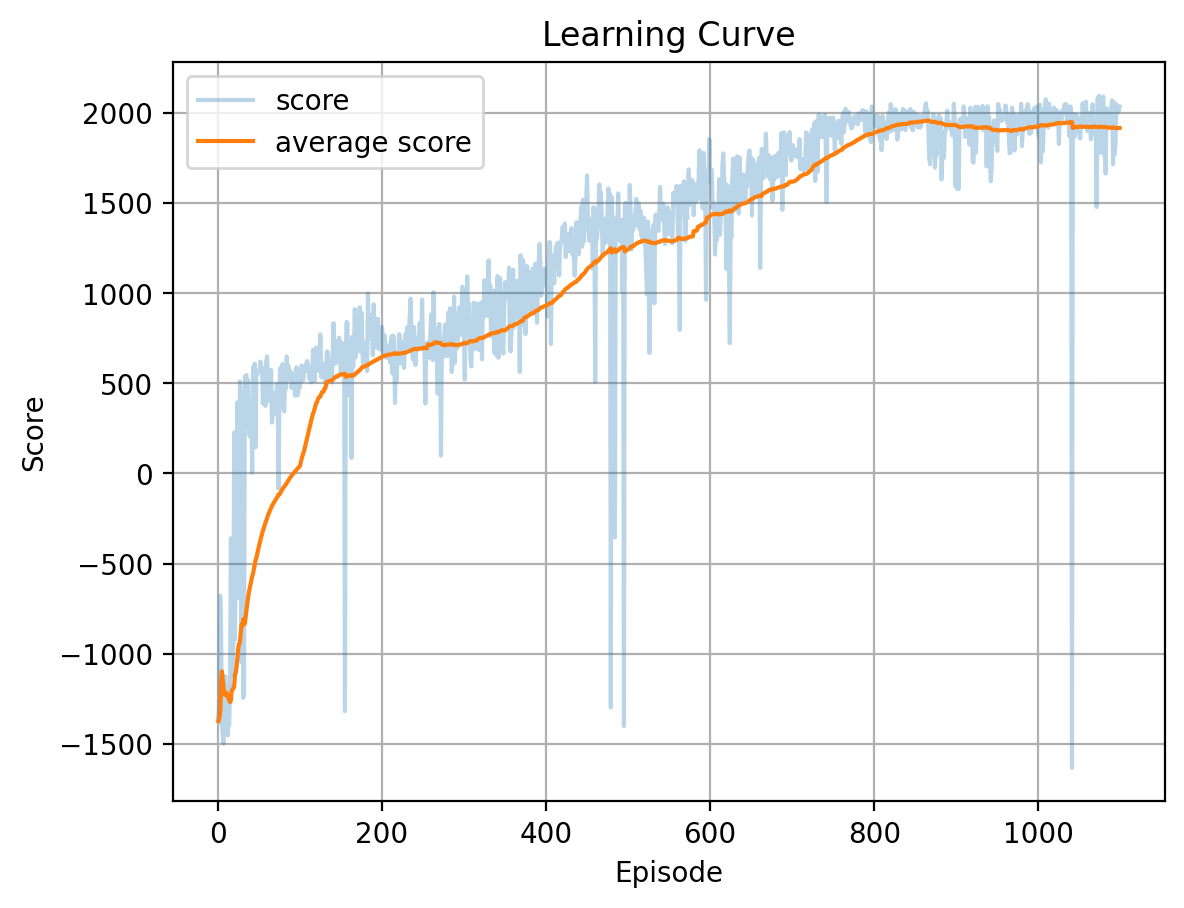

In [9]:
# Define the environment and agent
env = gym.make(env_name)
dir_path = os.path.join(dir, env_name)
os.makedirs(dir_path, exist_ok=True)

if record_video:
    env = RecordVideo(env, video_folder=os.path.join(dir_path, 'videos'),
                      episode_trigger=lambda ep: ep == n_games - 1)

agent = Agent(gamma=gamma, alpha=alpha, beta=beta,
              state_dims=env.observation_space.shape[0],
              action_dims=env.action_space.shape[0],
              max_action=float(env.action_space.high[0]),
              fc1_dim=fc1_dim, fc2_dim=fc2_dim,
              memory_size=memory_size, batch_size=batch_size,
              tau=tau, update_period=update_period,
              reward_scale=reward_scale, warmup=warmup,
              reparam_noise_lim=reparam_noise_lim,
              name='SAC_Agent', ckpt_dir=dir_path)

# TODO: Initialize performance tracking variables
scores = []
avg_scores = []
best_score = -np.inf

for game in trange(n_games):
    # TODO: Reset environment and initialize variables at the start of each episode
    state = env.reset()
    done = False
    score = 0

    # TODO: Interact with the environment until the episode is done
    while not done:
        action = agent.choose_action(state)
        state_, reward, done, info = env.step(action)
        agent.store_transition(state, action, reward, state_, done)
        agent.learn()
        score += reward
        state = state_

    # TODO: Track score and average score for plotting and saving
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    avg_scores.append(avg_score)

    print(f'| Game: {game:6.0f} | Score: {score:10.2f} | Best score: {best_score:10.2f} | '
          f'Avg score {avg_score:10.2f} | Learning iter: {agent.learn_iter:10.0f} |')

    # TODO: Save the model if the current avg score is better than the best so far
    if avg_score > best_score:
        best_score = avg_score
        agent.save_model()

env.close()

plot_learning_curve(scores, agent.full_path)

## 🚀 Training Loop

For each episode, interact with the environment to collect transitions, then update the SAC networks and save the best model.

After training, a learning curve is plotted to visualize convergence and performance stability.

## 🎥 Visualize Agent Behavior

This is the last episode recorded video of the trained agent interacting with the environment in training process.

In [10]:
Video(f"/content/tmp/HalfCheetahBulletEnv-v0/videos/rl-video-episode-{n_games-1}.mp4", embed=True, width=600)